# Gold Layer Exploration and Logistic Regression Modeling

This script:
1. Loads and explores the gold layer feature store
2. Performs EDA on features and target variable
3. Prepares data for modeling (feature selection, train/test split)
4. Trains a logistic regression model
5. Evaluates model performance with metrics and visualizations

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import pyspark
from pyspark.sql.functions import col
import pyspark.sql.functions as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

In [2]:
# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("ModelTraining") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/07 11:34:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/07 11:34:56 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/10/07 11:34:56 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [4]:
# Configuration
GOLD_DIR = "/app/datamart/gold/feature_store/"

# LOAD GOLD LAYER DATA

In [5]:
# Get all parquet files
parquet_files = glob.glob(os.path.join(GOLD_DIR, "*.parquet"))

if not parquet_files:
    print(f"❌ No parquet files found in {GOLD_DIR}")
    print("Run gold layer processing first:")
    print("  python run_gold_processing.py")
    spark.stop()
    exit(1)

print(f"\nFound {len(parquet_files)} partition files")
print("Loading all partitions...")


Found 24 partition files
Loading all partitions...


In [6]:
# Load with schema merging
df_spark = spark.read.option("mergeSchema", "true").parquet(*parquet_files)

print(f"✓ Loaded {df_spark.count():,} applications")
print(f"✓ Total features: {len(df_spark.columns)}")

[Stage 1:=======>                                                   (1 + 7) / 8]

✓ Loaded 150,018 applications
✓ Total features: 168


In [11]:
# Convert to Pandas for easier analysis and modeling
print("\nConverting to Pandas...")
df = df_spark.toPandas()
print(f"✓ Pandas DataFrame shape: {df.shape}")


Converting to Pandas...


✓ Pandas DataFrame shape: (150018, 168)


# BASIC EXPLORATION

In [12]:
print("\n--- Dataset Overview ---")
print(f"Total applications: {len(df):,}")
print(f"Total features: {len(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")


--- Dataset Overview ---
Total applications: 150,018
Total features: 168
Memory usage: 243.69 MB


In [13]:
# Check for target variable
if 'default_label' not in df.columns:
    print("\n❌ Error: 'default_label' column not found!")
    print("Available columns:", df.columns.tolist())
    spark.stop()
    exit(1)

In [15]:
# Target distribution
print("\n--- Target Variable Distribution ---")
default_counts = df['default_label'].value_counts()
default_rate = df['default_label'].mean() * 100
print(f"Non-defaults (0): {default_counts.get(0, 0):,} ({100-default_rate:.2f}%)")
print(f"Defaults (1): {default_counts.get(1, 0):,} ({default_rate:.2f}%)")


--- Target Variable Distribution ---
Non-defaults (0): 125,631 (83.74%)
Defaults (1): 24,387 (16.26%)


In [18]:
# Check for class imbalance
if default_rate < 10 or default_rate > 90:
    print(f"⚠️  WARNING: Imbalanced dataset (default rate: {default_rate:.2f}%)")
    print("   Consider using class weights or resampling techniques")
else:
    print("Not imbalanced")

Not imbalanced


In [19]:
# Date range
if 'application_date' in df.columns:
    print("\n--- Application Date Range ---")
    print(f"From: {df['application_date'].min()}")
    print(f"To: {df['application_date'].max()}")
    print(f"Unique dates: {df['application_date'].nunique()}")


--- Application Date Range ---
From: 2023-01-01
To: 2024-12-01
Unique dates: 24


In [21]:
# Missing values
print("\n--- Missing Values Summary ---")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'missing_count': missing,
    'missing_pct': missing_pct
})
missing_df = missing_df[missing_df['missing_count'] > 0].sort_values('missing_pct', ascending=False)

if len(missing_df) > 0:
    print(f"\nFeatures with missing values: {len(missing_df)}")
    print("\nTop 10 features with most missing values:")
    print(missing_df.head(10))
else:
    print("✓ No missing values found!")


--- Missing Values Summary ---

Features with missing values: 103

Top 10 features with most missing values:
               missing_count  missing_pct
fe_6_std_30d           97288    64.850885
fe_8_std_30d           97288    64.850885
fe_7_std_30d           97288    64.850885
fe_2_std_30d           97288    64.850885
fe_3_std_30d           97288    64.850885
fe_4_std_30d           97288    64.850885
fe_1_std_30d           97288    64.850885
fe_10_std_30d          97288    64.850885
fe_11_std_30d          97288    64.850885
fe_12_std_30d          97288    64.850885


# FEATURE ANALYSIS

In [22]:
# Identify feature types
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove non-feature columns
exclude_cols = ['loan_id', 'Customer_ID', 'application_date', 'snapshot_date', 'default_label']
numeric_features = [f for f in numeric_features if f not in exclude_cols]
categorical_features = [f for f in categorical_features if f not in exclude_cols]

print(f"\nNumeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")


Numeric features: 157
Categorical features: 6


In [24]:
# Key numeric features
key_numeric = ['DTI', 'log_Annual_Income', 'Annual_Income', 'Age', 
               'Credit_History_Age_Year', 'Num_of_Loan_active',
               'Num_of_Delayed_Payment_12m', 'EMI_to_income', 'loan_amt']
key_numeric = [f for f in key_numeric if f in df.columns]

print("\n--- Key Numeric Features Statistics ---")
df[key_numeric].describe()


--- Key Numeric Features Statistics ---


,DTI,log_Annual_Income,Annual_Income,Age,Credit_History_Age_Year,Num_of_Loan_active,Num_of_Delayed_Payment_12m,EMI_to_income,loan_amt
count,150018.000000,150018.000000,1.500180e+05,150018.000000,150018.000000,150018.000000,150018.000000,150018.000000,150018.0
mean,0.059487,10.590854,1.661432e+05,104.802010,18.728090,2.783073,33.977649,0.449422,10000.0
std,0.086620,0.951409,1.329327e+06,666.492124,8.298443,61.793231,249.196361,0.366625,0.0
min,0.000002,8.854512,7.005930e+03,-500.000000,0.666667,-100.000000,-3.000000,0.000532,10000.0
25%,0.009436,9.880703,1.954947e+04,25.000000,12.333333,1.000000,9.000000,0.175022,10000.0
50%,0.027911,10.540716,3.782465e+04,34.000000,18.666667,3.000000,14.000000,0.334963,10000.0
75%,0.067623,11.189822,7.238988e+04,42.000000,25.416667,5.000000,18.000000,0.648092,10000.0
max,0.683252,16.986653,2.383470e+07,8678.000000,33.666667,1495.000000,4293.000000,1.808446,10000.0


In [25]:
# Correlation with target
print("\n--- Top 15 Features Correlated with Default ---")
correlations = []
for col_name in numeric_features:
    if col_name in df.columns:
        try:
            corr = df[['default_label', col_name]].corr().iloc[0, 1]
            if not np.isnan(corr):
                correlations.append((col_name, corr))
        except:
            pass

correlations.sort(key=lambda x: abs(x[1]), reverse=True)

print("\nFeature                              Correlation")
print("-" * 60)
for feat, corr in correlations[:15]:
    direction = "↑ Risk+" if corr > 0 else "↓ Risk-"
    print(f"{feat:35s} {corr:+.4f}  {direction}")


--- Top 15 Features Correlated with Default ---

Feature                              Correlation
------------------------------------------------------------
Outstanding_Debt                    +0.2161  ↑ Risk+
Credit_Mix_Bad                      +0.1976  ↑ Risk+
Credit_History_Age_Month            -0.1932  ↓ Risk-
Credit_History_Age_Year             -0.1932  ↓ Risk-
loan_type_count                     +0.1888  ↑ Risk+
DTI                                 +0.1682  ↑ Risk+
Credit_Mix_Good                     -0.1116  ↓ Risk-
EMI_to_income                       +0.1062  ↑ Risk+
fe_10_mean_30d                      -0.0997  ↓ Risk-
fe_10_sum_7d                        -0.0948  ↓ Risk-
fe_10_mean_7d                       -0.0948  ↓ Risk-
fe_10_sum_30d                       -0.0936  ↓ Risk-
log_Annual_Income                   -0.0934  ↓ Risk-
fe_5_mean_30d                       +0.0903  ↑ Risk+
fe_5_sum_30d                        +0.0844  ↑ Risk+


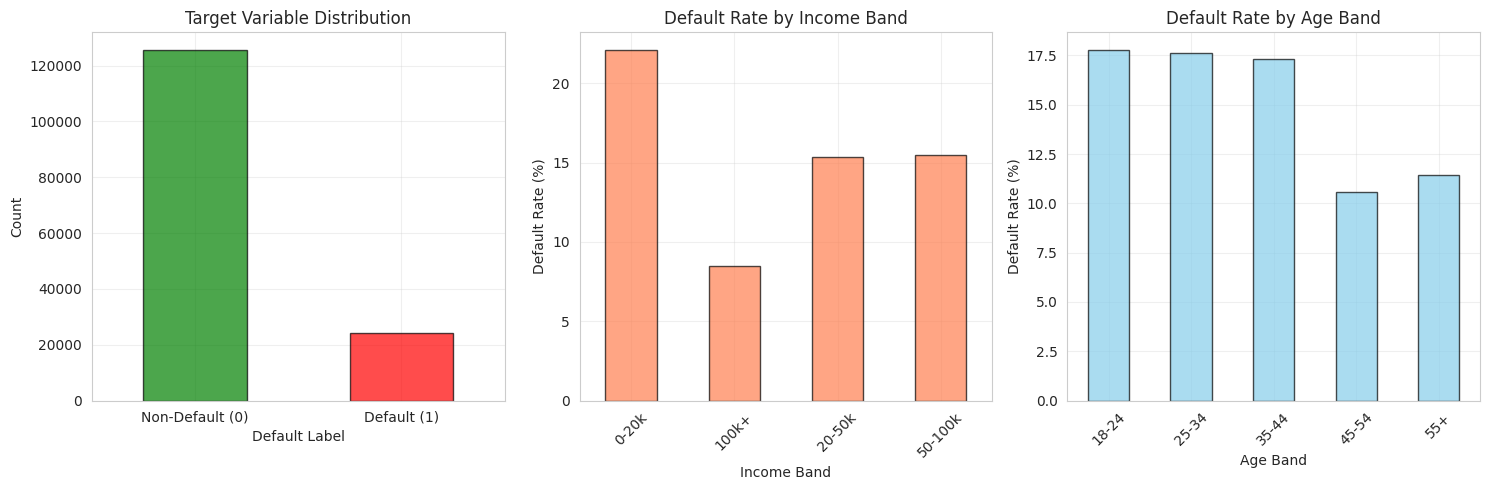


✓ Saved: gold_target_distribution.png


In [26]:
# Visualization: Target distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['default_label'].value_counts().plot(kind='bar', color=['green', 'red'], alpha=0.7, edgecolor='black')
plt.xlabel('Default Label')
plt.ylabel('Count')
plt.title('Target Variable Distribution')
plt.xticks([0, 1], ['Non-Default (0)', 'Default (1)'], rotation=0)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
if 'income_band' in df.columns:
    default_by_income = df.groupby('income_band')['default_label'].mean() * 100
    default_by_income.plot(kind='bar', color='coral', alpha=0.7, edgecolor='black')
    plt.xlabel('Income Band')
    plt.ylabel('Default Rate (%)')
    plt.title('Default Rate by Income Band')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
if 'age_band' in df.columns:
    default_by_age = df.groupby('age_band')['default_label'].mean() * 100
    default_by_age.plot(kind='bar', color='skyblue', alpha=0.7, edgecolor='black')
    plt.xlabel('Age Band')
    plt.ylabel('Default Rate (%)')
    plt.title('Default Rate by Age Band')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gold_target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Saved: gold_target_distribution.png")

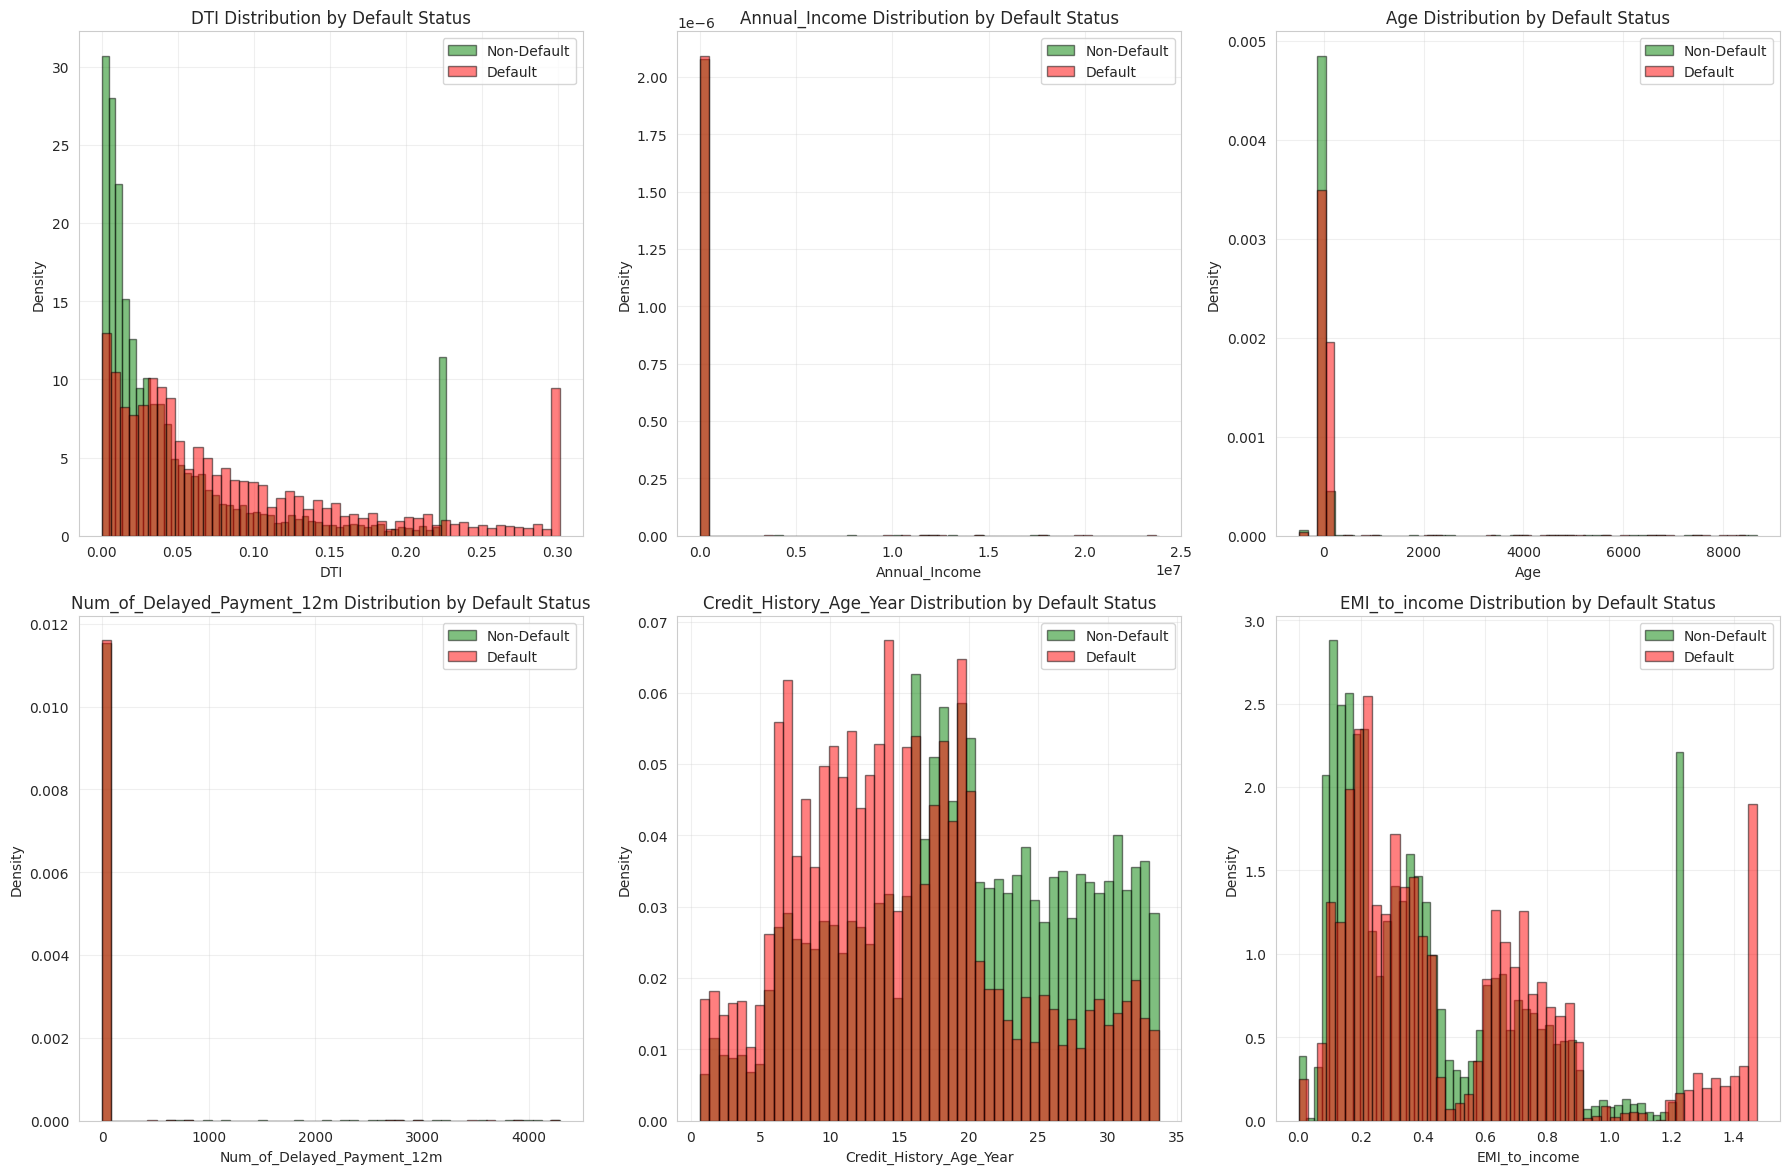

✓ Saved: gold_feature_distributions.png


In [27]:
# Visualization: Feature distributions by default status
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

plot_features = ['DTI', 'Annual_Income', 'Age', 'Num_of_Delayed_Payment_12m', 
                'Credit_History_Age_Year', 'EMI_to_income']
plot_features = [f for f in plot_features if f in df.columns]

for idx, feature in enumerate(plot_features[:6]):
    ax = axes[idx]
    
    non_default = df[df['default_label'] == 0][feature].dropna()
    default = df[df['default_label'] == 1][feature].dropna()
    
    # Handle outliers for better visualization
    if feature in ['DTI', 'EMI_to_income']:
        non_default = non_default.clip(upper=non_default.quantile(0.95))
        default = default.clip(upper=default.quantile(0.95))
    
    ax.hist(non_default, bins=50, alpha=0.5, label='Non-Default', 
           color='green', edgecolor='black', density=True)
    ax.hist(default, bins=50, alpha=0.5, label='Default', 
           color='red', edgecolor='black', density=True)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.set_title(f'{feature} Distribution by Default Status')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gold_feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: gold_feature_distributions.png")


# DATA PREPARATION FOR MODELING

In [28]:
# Select features for modeling
print("\n--- Feature Selection ---")

# Strategy: Use numeric features with low missing values
# Filter out features with >50% missing values
valid_features = []
for feat in numeric_features:
    missing_pct = df[feat].isnull().sum() / len(df) * 100
    if missing_pct < 50:
        valid_features.append(feat)

print(f"Total numeric features: {len(numeric_features)}")
print(f"Valid features (< 50% missing): {len(valid_features)}")


--- Feature Selection ---
Total numeric features: 157
Valid features (< 50% missing): 137


In [29]:
# Create modeling dataset
print("\n--- Creating Modeling Dataset ---")

# Select features and target
X = df[valid_features].copy()
y = df['default_label'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")


--- Creating Modeling Dataset ---
Feature matrix shape: (150018, 137)
Target vector shape: (150018,)


In [31]:
# Handle missing values (simple imputation with median)
print("\n--- Handling Missing Values ---")
missing_before = X.isnull().sum().sum()
X = X.fillna(X.median())
missing_after = X.isnull().sum().sum()
print(f"Missing values before imputation: {missing_before:,}")
print(f"Missing values after imputation: {missing_after:,}")


--- Handling Missing Values ---
Missing values before imputation: 0
Missing values after imputation: 0


In [32]:
# Handle infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

In [33]:
# Remove constant features (zero variance)
print("\n--- Removing Constant Features ---")
constant_features = [col for col in X.columns if X[col].nunique() <= 1]
if constant_features:
    print(f"Removing {len(constant_features)} constant features")
    X = X.drop(columns=constant_features)
    print(f"Features after removal: {len(X.columns)}")


--- Removing Constant Features ---
Removing 5 constant features
Features after removal: 132


In [36]:
# Feature importance using correlation (for feature selection)
print("\n--- Feature Selection by Correlation ---")
correlations_with_target = []
for col_name in X.columns:
    corr = np.corrcoef(X[col_name], y)[0, 1]
    if not np.isnan(corr):
        correlations_with_target.append((col_name, abs(corr)))

correlations_with_target.sort(key=lambda x: x[1], reverse=True)

# Select top 20 most correlated features
top_n_features = 20
selected_features = [feat for feat, corr in correlations_with_target[:top_n_features]]

print(f"\nSelecting top {top_n_features} features by correlation:")
for i, (feat, corr) in enumerate(correlations_with_target[:top_n_features], 1):
    print(f"  {i:2d}. {feat:40s} {corr:.4f}")

X_selected = X[selected_features].copy()

print(f"\n✓ Final feature matrix shape: {X_selected.shape}")


--- Feature Selection by Correlation ---

Selecting top 20 features by correlation:
   1. Outstanding_Debt                         0.2161
   2. Credit_Mix_Bad                           0.1976
   3. Credit_History_Age_Month                 0.1932
   4. Credit_History_Age_Year                  0.1932
   5. loan_type_count                          0.1888
   6. DTI                                      0.1682
   7. Credit_Mix_Good                          0.1116
   8. EMI_to_income                            0.1062
   9. fe_10_mean_30d                           0.0994
  10. fe_10_sum_7d                             0.0945
  11. fe_10_mean_7d                            0.0945
  12. log_Annual_Income                        0.0934
  13. fe_10_sum_30d                            0.0906
  14. fe_5_mean_30d                            0.0895
  15. fe_5_sum_30d                             0.0855
  16. Type_of_Loan_Home_Equity_Loan            0.0816
  17. Type_of_Loan_Credit_Builder_Loan         0.08

In [38]:
# Train-test split
print("\n--- Train-Test Split ---")
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Training default rate: {y_train.mean()*100:.2f}%")
print(f"Test default rate: {y_test.mean()*100:.2f}%")



--- Train-Test Split ---
Training set: 105,012 samples
Test set: 45,006 samples
Training default rate: 16.26%
Test default rate: 16.26%


In [39]:
# Feature scaling
print("\n--- Feature Scaling (Standardization) ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardized (mean=0, std=1)")


--- Feature Scaling (Standardization) ---
✓ Features standardized (mean=0, std=1)


# LOGISTIC REGRESSION MODEL

In [40]:
# Calculate class weights for imbalanced data
class_weight_ratio = (len(y_train) - y_train.sum()) / y_train.sum()
print(f"\nClass imbalance ratio: {class_weight_ratio:.2f}:1 (non-default:default)")


Class imbalance ratio: 5.15:1 (non-default:default)


In [41]:
# Train logistic regression
print("\nTraining Logistic Regression with class weights...")

lr_model = LogisticRegression(
    class_weight='balanced',  # Handle class imbalance
    max_iter=1000,
    random_state=42,
    solver='lbfgs'
)

lr_model.fit(X_train_scaled, y_train)

print("✓ Model trained successfully")


Training Logistic Regression with class weights...
✓ Model trained successfully


In [42]:
# Feature coefficients
print("\n--- Feature Coefficients (Top 10) ---")
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'coefficient': lr_model.coef_[0]
})
feature_importance['abs_coefficient'] = feature_importance['coefficient'].abs()
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

print("\nFeature                              Coefficient   Impact")
print("-" * 70)
for idx, row in feature_importance.head(10).iterrows():
    impact = "↑ Increases Risk" if row['coefficient'] > 0 else "↓ Decreases Risk"
    print(f"{row['feature']:35s} {row['coefficient']:+8.4f}   {impact}")


--- Feature Coefficients (Top 10) ---

Feature                              Coefficient   Impact
----------------------------------------------------------------------
Outstanding_Debt                     +0.3767   ↑ Increases Risk
fe_10_sum_30d                        -0.2069   ↓ Decreases Risk
DTI                                  -0.2010   ↓ Decreases Risk
EMI_to_income                        +0.1942   ↑ Increases Risk
fe_5_sum_30d                         +0.1658   ↑ Increases Risk
fe_5_mean_30d                        +0.1554   ↑ Increases Risk
Credit_Mix_Bad                       +0.1472   ↑ Increases Risk
loan_type_count                      +0.0964   ↑ Increases Risk
Credit_History_Age_Year              -0.0894   ↓ Decreases Risk
Credit_History_Age_Month             -0.0894   ↓ Decreases Risk


# MODEL EVALUATION

In [43]:
# Predictions
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

y_train_proba = lr_model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

In [47]:
# Training metrics
print("\n--- Training Set Performance ---")
print(classification_report(y_train, y_train_pred, 
                          target_names=['Non-Default', 'Default']))

train_auc = roc_auc_score(y_train, y_train_proba)
print(f"ROC-AUC Score: {train_auc:.4f}")

# Test metrics
print("\n--- Test Set Performance ---")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Non-Default', 'Default']))

test_auc = roc_auc_score(y_test, y_test_proba)
print(f"ROC-AUC Score: {test_auc:.4f}")

# Check for overfitting
auc_diff = train_auc - test_auc
if auc_diff > 0.05:
    print(f"\n⚠️  WARNING: Possible overfitting detected (AUC diff: {auc_diff:.4f})")
else:
    print(f"\n✓ Model generalizes well (AUC diff: {auc_diff:.4f})")

# Confusion matrix
print("\n--- Confusion Matrix (Test Set) ---")
cm = confusion_matrix(y_test, y_test_pred)
print("\n                 Predicted")
print("               Non-Default  Default")
print(f"Actual Non-Default  {cm[0,0]:6d}     {cm[0,1]:6d}")
print(f"       Default      {cm[1,0]:6d}     {cm[1,1]:6d}")


--- Training Set Performance ---
              precision    recall  f1-score   support

 Non-Default       0.91      0.70      0.79     87941
     Default       0.29      0.64      0.40     17071

    accuracy                           0.69    105012
   macro avg       0.60      0.67      0.59    105012
weighted avg       0.81      0.69      0.73    105012

ROC-AUC Score: 0.7138

--- Test Set Performance ---
              precision    recall  f1-score   support

 Non-Default       0.91      0.70      0.79     37690
     Default       0.29      0.65      0.40      7316

    accuracy                           0.69     45006
   macro avg       0.60      0.67      0.60     45006
weighted avg       0.81      0.69      0.73     45006

ROC-AUC Score: 0.7175

✓ Model generalizes well (AUC diff: -0.0037)

--- Confusion Matrix (Test Set) ---

                 Predicted
               Non-Default  Default
Actual Non-Default   26330      11360
       Default        2597       4719


# VISUALIZATIONS

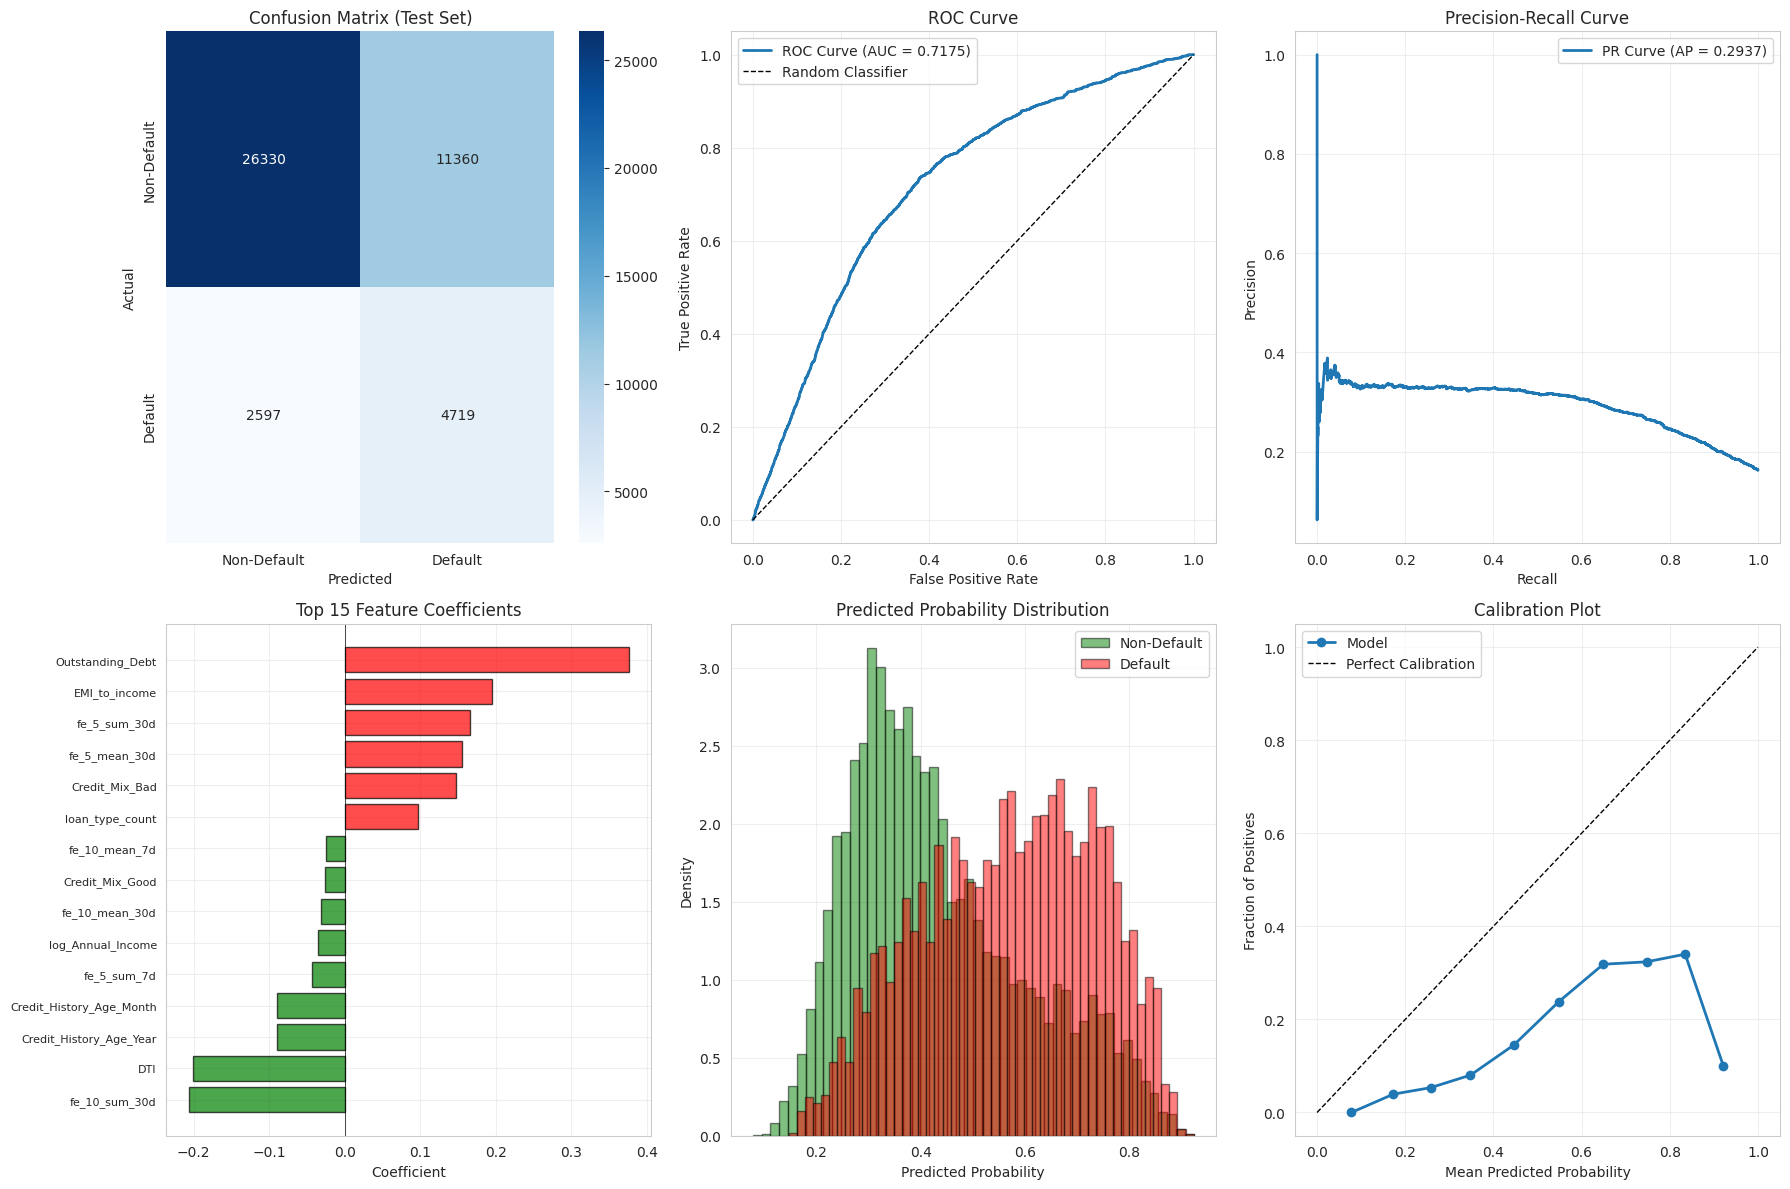


✓ Saved: logistic_regression_evaluation.png


In [48]:
# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Default', 'Default'],
            yticklabels=['Non-Default', 'Default'])
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# 2. ROC Curve
ax2 = plt.subplot(2, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Precision-Recall Curve
ax3 = plt.subplot(2, 3, 3)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
avg_precision = average_precision_score(y_test, y_test_proba)
plt.plot(recall, precision, linewidth=2, label=f'PR Curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Feature Coefficients
ax4 = plt.subplot(2, 3, 4)
top_features = feature_importance.head(15).sort_values('coefficient')
colors = ['red' if x > 0 else 'green' for x in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7, edgecolor='black')
plt.yticks(range(len(top_features)), top_features['feature'], fontsize=8)
plt.xlabel('Coefficient')
plt.title('Top 15 Feature Coefficients')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3)

# 5. Predicted Probability Distribution
ax5 = plt.subplot(2, 3, 5)
plt.hist(y_test_proba[y_test == 0], bins=50, alpha=0.5, label='Non-Default', 
         color='green', edgecolor='black', density=True)
plt.hist(y_test_proba[y_test == 1], bins=50, alpha=0.5, label='Default', 
         color='red', edgecolor='black', density=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Predicted Probability Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Calibration plot (optional)
ax6 = plt.subplot(2, 3, 6)
from sklearn.calibration import calibration_curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, y_test_proba, n_bins=10
)
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', linewidth=2, label='Model')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('logistic_regression_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Saved: logistic_regression_evaluation.png")

# MODEL SUMMARY

In [49]:
print(f"""
📊 DATASET:
   • Total applications: {len(df):,}
   • Training samples: {len(X_train):,}
   • Test samples: {len(X_test):,}
   • Features used: {len(selected_features)}
   • Default rate: {df['default_label'].mean()*100:.2f}%

🎯 MODEL PERFORMANCE (Test Set):
   • ROC-AUC: {test_auc:.4f}
   • Precision (Default class): {classification_report(y_test, y_test_pred, output_dict=True)['1']['precision']:.4f}
   • Recall (Default class): {classification_report(y_test, y_test_pred, output_dict=True)['1']['recall']:.4f}
   • F1-Score (Default class): {classification_report(y_test, y_test_pred, output_dict=True)['1']['f1-score']:.4f}

🔝 TOP 5 RISK FACTORS (Positive Coefficients):
""")

for idx, row in feature_importance[feature_importance['coefficient'] > 0].head(5).iterrows():
    print(f"   {row['feature']:35s} +{row['coefficient']:.4f}")

print(f"""
🛡️  TOP 5 PROTECTIVE FACTORS (Negative Coefficients):
""")

for idx, row in feature_importance[feature_importance['coefficient'] < 0].head(5).iterrows():
    print(f"   {row['feature']:35s} {row['coefficient']:.4f}")

print("\n" + "="*80)
print("✅ EXPLORATION AND MODELING COMPLETED")
print("="*80)


📊 DATASET:
   • Total applications: 150,018
   • Training samples: 105,012
   • Test samples: 45,006
   • Features used: 20
   • Default rate: 16.26%

🎯 MODEL PERFORMANCE (Test Set):
   • ROC-AUC: 0.7175
   • Precision (Default class): 0.2935
   • Recall (Default class): 0.6450
   • F1-Score (Default class): 0.4034

🔝 TOP 5 RISK FACTORS (Positive Coefficients):

   Outstanding_Debt                    +0.3767
   EMI_to_income                       +0.1942
   fe_5_sum_30d                        +0.1658
   fe_5_mean_30d                       +0.1554
   Credit_Mix_Bad                      +0.1472

🛡️  TOP 5 PROTECTIVE FACTORS (Negative Coefficients):

   fe_10_sum_30d                       -0.2069
   DTI                                 -0.2010
   Credit_History_Age_Year             -0.0894
   Credit_History_Age_Month            -0.0894
   fe_5_sum_7d                         -0.0429

✅ EXPLORATION AND MODELING COMPLETED


# 💡 Next Steps:
   1. Try more advanced models (Random Forest, XGBoost, LightGBM)
   2. Perform hyperparameter tuning
   3. Implement cross-validation
   4. Feature engineering (polynomial features, interactions)
   5. Ensemble methods
   6. Deploy model to production

In [50]:
# Cleanup
spark.stop()
print("\n✓ Spark session stopped")


✓ Spark session stopped
